# 6.2 Understanding recurrent neural networks

A major characteristic of all neural networks we've seen so far, is that **they have no memory**. **Each input shown to them is processed independently, with no *state* kept in between inputs**. Thus in order to process a sequence or a temporal series of data points, we have to show the entire sequence to the network at once and proceess in one go.

### Such networks are called *feedforward networks* (前馈网络)

In contrast, when reading the sentence, you're processing it word by word (or eye saccade by eye saccade), while keeping memories of what came before, this gives us a fluid representation of the meaning conveyed in the sentence.

### Biological intelligence processes information incrementally while maintaining an internal model of what it's processing, built from past information and constantly updated as new information comes in.

A ***recurrent neural network (RNN)*** adopts the same principle but in a simpler version: it processes sequences by iterating through the sequence elements and maintaining a ***state*** containing information relatve to what it has seen so far.

In effect, RNN is a type of neural network that has an **internal loop**. The state of the RNN is reset between processing two different, independent sequences (e.g. two different IMDB reviews). So we consider one sequence a single input(data point) into the neural network. What changes is that this data point is no longer processed in a single step, rather, **the network will internally loops over sequence elements**.

### To make these notions of *loop* and *state* more clear, we implement the forward pass of a toy RNN in Numpy.

It takes as input a sequence of vectors of shape **(timesteps, input_features)**. It **loops over timesteps**, and at each timestep, it considers its current state at **t** and input at **t** of shape**(input_features,)** and combine them to obtain the output at **t**.

**Then we set the state for the next step to be this previous output.** For the first timestep, since no previous output is defined, we initialize the state as an all-zero vector, called the ***initial state*** of the network.

In [ ]:
# Pseudocode RNN

state_t = 0  # the state at t

for input_t in input_sequence:    # Iterates over sequence elements
    output_t = f(input_t, state_t)
    state_t = output_t   # previous output becomes the state for the next iteration

### You can even flesh the function f: the transformation of the input an state into an output that is parameterized by two matrices: *W* and *U*,  and a bias vector *b* (similar to Dense layer in a feedforward network)

In [ ]:
state_t = 0

for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

### To make it more concrete,  we write a naive Numpy implementation of the forward pass of the simple RNN:

In [ ]:
import numpy as np

timesteps = 100
input_features = 32 # Dimensionality of input feature space
output_features = 64

inputs = np.random.random((timesteps, input_features)) # input data: random noise 

state_t = np.zeros((output_features,))  # Initial state: all-zero vector

# Create random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = [] # stores the output in a list

for input_t in inputs: # loops every timestep
    
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    successive_outputs.append(output_t)
    
    state_t = output_t # update the state for the next timestep

final_output_sequence = np.concatenate(successive_outputs, axis = 0)
# a 2D tensor of shape (timesteps, output_features), each timestep is the output of the loop at time t

### Easy summary: an RNN is a for loop that  reuses quantities computed during the previous iteration of the loop, nothing more. Of course, there are many other variations of RNN fitting this definition we could build.

### RNN is characterized by their step function, such as the case used above:
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

### Note that the final output is a 2D tensor of shape (timesteps, output_features),  where each timestep is the output of the loop at time t. Each timestep t in the output tensor contains information about timesteps 0 to t in the  input sequence ---- *about the entire past* 

### For this reason, in many cases, we don't need this full sequence of outputs, we just need the last output, because it already contains information about the entire sequence.

## 6.2.1 A recurrent layer in Keras

The naive implementation we've just done corresponds to an actual Keras layer --- the **SimpleRNN** layer

The only minor difference is: **SimpleRNN processes batches of sequences**, not a single sequence in the naive example. This means it will take inputs of shape **(batch_size, timesteps, input_features)**

Like all recurrent layers in Keras, SimpleRNN can be run in **two different modes**:

1) return the full sequence of successive outputs for each timestep (3D  tensor of shape **(batch_size, timesteps, output_features)**);

2) only return the last output for each input sequence (2D tensor of shape **(batch_size, output_features)**);

These two modes are controlled by the **return_sequences** constructor argument.

### Let's first see an example uses SimpleRNN and returns only the output at the last timestep (Default)

In [1]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))

model.summary()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### The following example returns the full state sequence:

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences = True))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### It's sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return full sequence of outputs:

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32))  #  last layer only returns the last output

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


### Now we use such a model on IMDB set. First, preprocess the data:

In [5]:
# Preparing the IMDB data
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000   # number of words to consider as features
maxlen = 500    # cut off texts after this many words
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequence')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen = maxlen)
input_test = sequence.pad_sequences(input_test, maxlen = maxlen)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...


/home/yanbo/.local/lib/python3.6/site-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/yanbo/.local/lib/python3.6/site-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


25000 train sequences
25000 test sequence
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


### Let's train a simple recurrent network using an Embedding layer and a SimpleRNN layer

In [10]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [11]:
history = model.fit(input_train, y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 19s 967us/step - loss: 0.6407 - acc: 0.6225 - val_loss: 0.5135 - val_acc: 0.7904
Epoch 2/10
20000/20000 [==============================] - 17s 830us/step - loss: 0.3886 - acc: 0.8375 - val_loss: 0.5284 - val_acc: 0.7482
Epoch 3/10
20000/20000 [==============================] - 17s 826us/step - loss: 0.2769 - acc: 0.8935 - val_loss: 0.3710 - val_acc: 0.8434
Epoch 4/10
20000/20000 [==============================] - 17s 826us/step - loss: 0.2269 - acc: 0.9124 - val_loss: 0.4087 - val_acc: 0.8270
Epoch 5/10
20000/20000 [==============================] - 17s 831us/step - loss: 0.1688 - acc: 0.9370 - val_loss: 0.4520 - val_acc: 0.8036
Epoch 6/10
20000/20000 [==============================] - 17s 834us/step - loss: 0.1110 - acc: 0.9634 - val_loss: 0.4107 - val_acc: 0.8626
Epoch 7/10
20000/20000 [==============================] - 17s 833us/step - loss: 0.0843 - acc: 0.9725 - val_loss: 0.4

### Now we display the training and validation loss and accuracy

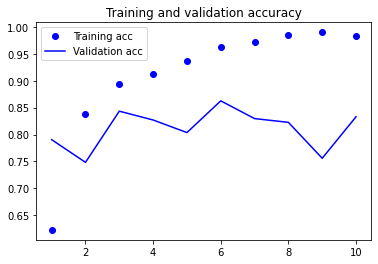

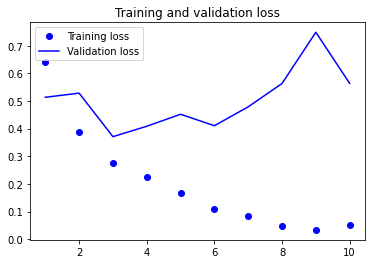

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, the naive approach in Chapter 3 got you to a validation accuracy of 88%. Unfortuantely, this small recurrent network does not perform well compared to this baseline (only 85% validation accuracy).

### The problem may lie in two parts:
### 1) your inputs cut the texts after the first 500 words, rather than the full sequences --- hence the RNN has less information than the baseline model;
### 2) SImpleRNN is not good at processing long sequences, such as texts. Other types of recurrent layers perform much better.

Let's see some more-advanced layers.

## 6.2.2 Understanding the LSTM and GRU layers

In practice, SimpleRNN is generally too simplistic to be of real use. There are two other recurrent layers available in Keras: **LSTM** and **GRU**. we always choose one of these.

SimpleRNN has a major issue: 
### Although it could theoretically retain at time t information about inputs seen many timesteps before, in practice, such long-term dependencies are impossible to learn.

This is due to the ***vanishing gradient problem***, an effect that is similar to what is observed in feedforward networks that are many layers deep: 
### As you keep adding layers to a network, the network eventually becomes untrainable.

The theoretical reasons for this effect were studied by **Hochreiter, Schmidhuber, and Bengio** in the early 1990s. The LSTM and GRU layers are designed to solve this problem.

### LSTM (Long Short-Term Memory)

Developed by Hochreiter and Schmidhuber in 1997, the culmination of their research on vanishing gradient problem.
This layer is a variant of the SimpleRNN: **it adds a way to carry information across many timesteps**.

Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, **be transported to a later timestep**, and jump off, intact, when you need it. 

### This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.

### To understand it in detail, let's start from the SimpleRNN cell, we index the W and U matrices in the cell with the letter o (Wo and Uo) for *output*

In [ ]:
output_t = activation(Wo * input_t + Uo * state_t + bo)

### Let's add this addtional data flow that carries information across timesteps. Call its values at different timesteps Ct, where *C* stands for *carry*. Now the output will become: 

In [ ]:
output_t = activation(Wo * input_t + Uo * state_t + Vo * c_t + bo)

### Now comes the subtlety: the way the next value of the carry dataflow is computed (i.e. How to compute C_t from C_t-1 ): It involves 3 distinct transformations, all of them have the form of a SimpleRNN cell:

In [ ]:
y = activation(dot(state_t, U) + dot(input_t, W) + b)

### But all three transformations have their own weight matrices, which we index with i, f, k

In [ ]:
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

### Then we obtain the new carry state C_t+1 by combining i_t, f_t, k_t.

In [ ]:
C_t+1 = i_t * k_t + C_t * f_t

You can interpret what each of these operations is meant to do. For instance, you can say that multiplying c_t and f_t is a way to deliberately forget irrelevant information in the carry dataflow. Meanwhile, i_t and k_t provide information about the present, updating the carry track with new information.

But at the end of the day, these interpretations don’t mean much, because **what these operations actually do is determined by the contents of the weights parameterizing them**; and the weights are learned in an end-to-end fashion, starting over with each training round, making it impossible to credit this or that operation with a specific purpose. 

**The specification of an RNN cell (as just described) determines your hypothesis space**—the space in which you’ll search for a good model configuration during training—**but it doesn’t determine what the cell does; that is up to the cell weights**. The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of constraints on your search, not as a design in an engineering sense.

It seems that **the choice of such constraints—the question of how to implement RNN cells—is better left to optimization algorithms (like genetic algorithms or reinforcement learning processes) than to human engineers**. As a human, it shouldn’t be your job to understand it.

## 6.2.3 A concrete LSTM example in Keras

### We set up a model using LSTM layer and train it on the IMDB data, we only specify the output dimensionality of the LSTM layer, leave other arguments as defaults in Keras. Keras has good defaults, and things will almost 'just work' without you spending time tuning parameters by hand.

In [14]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [15]:
history = model.fit(input_train, y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.5363 - acc: 0.7472 - val_loss: 0.4020 - val_acc: 0.8324
Epoch 2/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.3141 - acc: 0.8766 - val_loss: 0.3692 - val_acc: 0.8398
Epoch 3/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.2361 - acc: 0.9095 - val_loss: 0.3167 - val_acc: 0.8640
Epoch 4/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.2037 - acc: 0.9247 - val_loss: 0.3141 - val_acc: 0.8626
Epoch 5/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.1745 - acc: 0.9367 - val_loss: 0.3403 - val_acc: 0.8732
Epoch 6/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.1616 - acc: 0.9434 - val_loss: 0.4302 - val_acc: 0.8488
Epoch 7/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.1453 - acc: 0.9491 - val_loss: 0.3104 - val_acc:

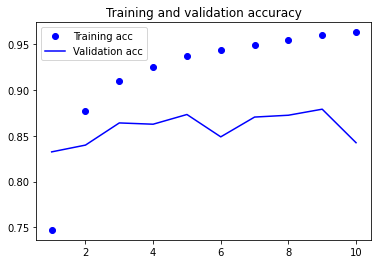

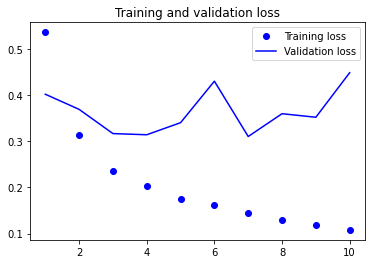

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### This time we achieve up to 88% validation accuracy. Not bad, certainly better than SimpleRNN, largely because LSTM suffers much less from the vanishing-gradiet problem ---- and slightly better tha fully connected approach from Chapter3, even though we look at less data (truncating sequences after 500 timesteps)

### But this result is  not groundbreaking for such a computationally intensive appraoch. Why isn't LSTM performing better ? 

### 1) One reason might be no effort made to tune hyperparameters (e.g dimensionality);
### 2) Another might be lack of regularization;

### But honestly, the primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good at) is not helpful for a sentiment-analysis problem.

### Such a basic problem is well solved by looking at key words and their frequency, that' s what the fully connected appraoch looked at.

### But there are far more difficult problem in NLP, where the strength of LSTM will become apparent: in particular, question-answering and machine translation.